In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [7]:
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

train_df Shape: (243787, 21)
test_df Shape: (104480, 20)
Rows   : 243787
Columns : 21
Index(['AccountAge', 'MonthlyCharges', 'TotalCharges', 'SubscriptionType',
       'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess',
       'DeviceRegistered', 'ViewingHoursPerWeek', 'AverageViewingDuration',
       'ContentDownloadsPerMonth', 'GenrePreference', 'UserRating',
       'SupportTicketsPerMonth', 'Gender', 'WatchlistSize', 'ParentalControl',
       'SubtitlesEnabled', 'CustomerID', 'Churn'],
      dtype='object')

Features : 
 ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'GenrePreference', 'UserRating', 'SupportTicketsPerMonth', 'Gender', 'WatchlistSize', 'ParentalControl', 'SubtitlesEnabled', 'CustomerID', 'Churn']

Unique values : 
 AccountAge                     119
MonthlyC

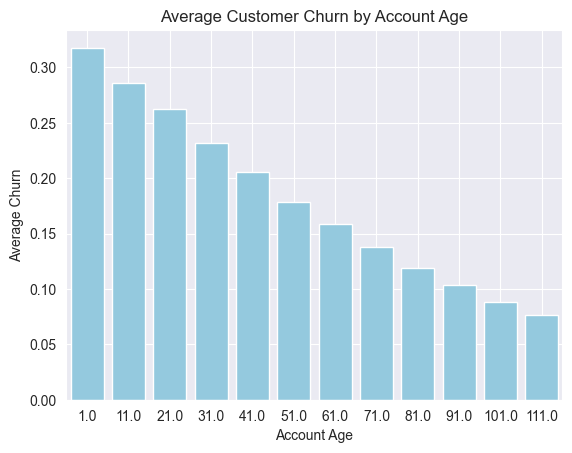

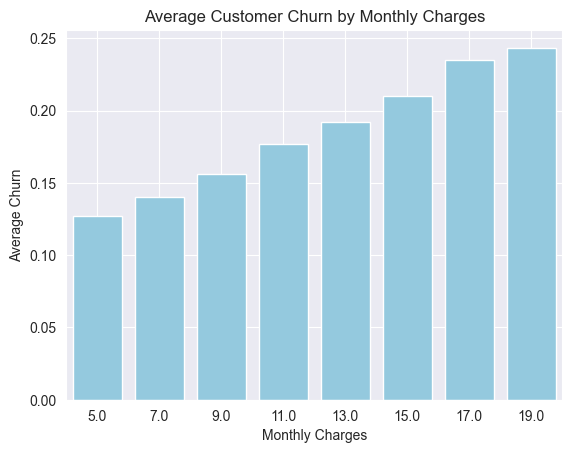

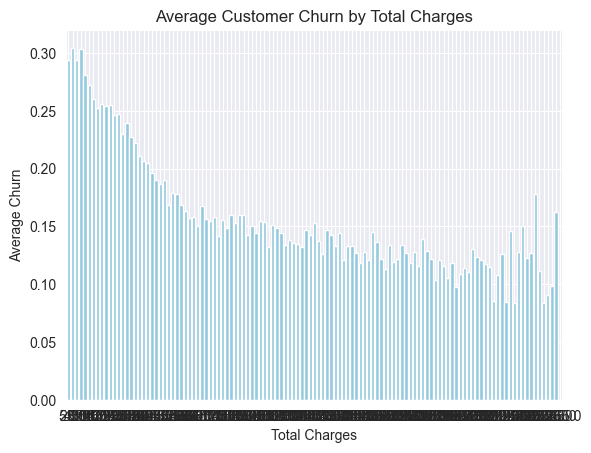

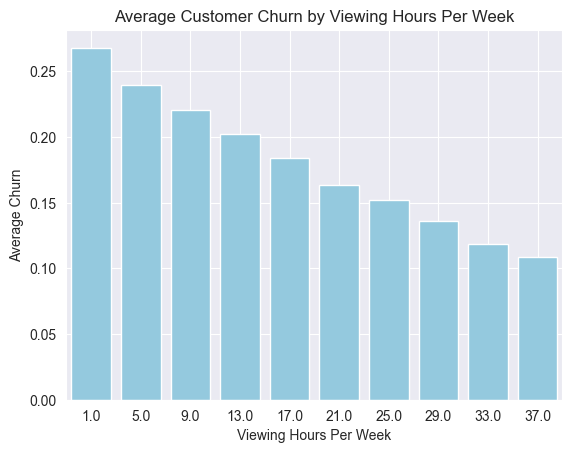

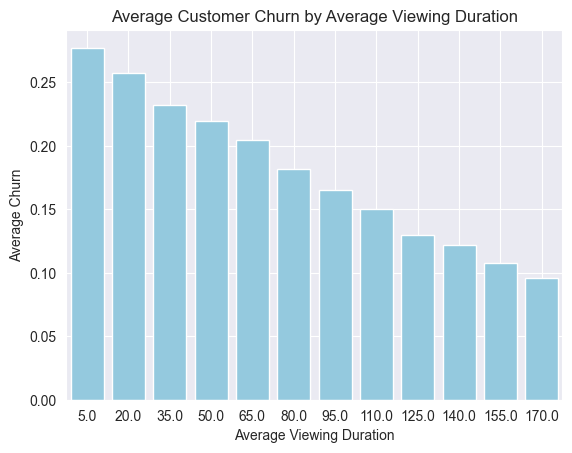

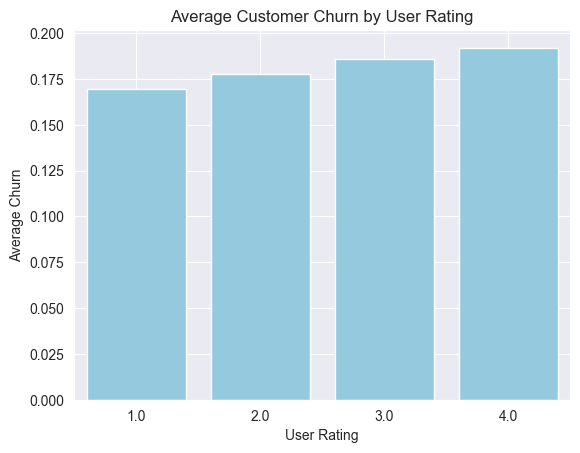

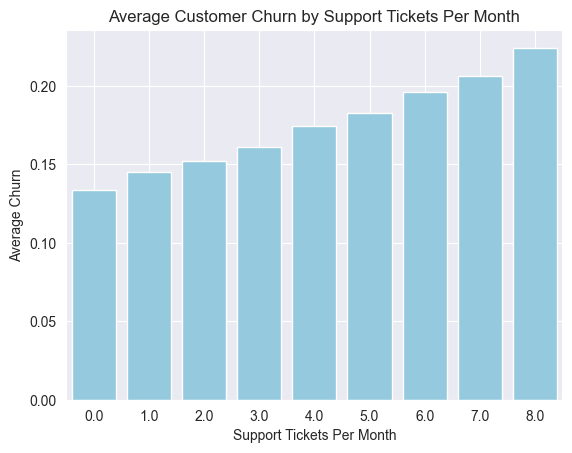

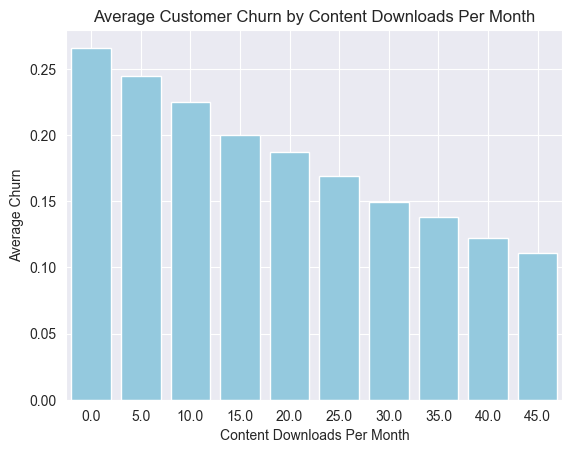

['SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled']


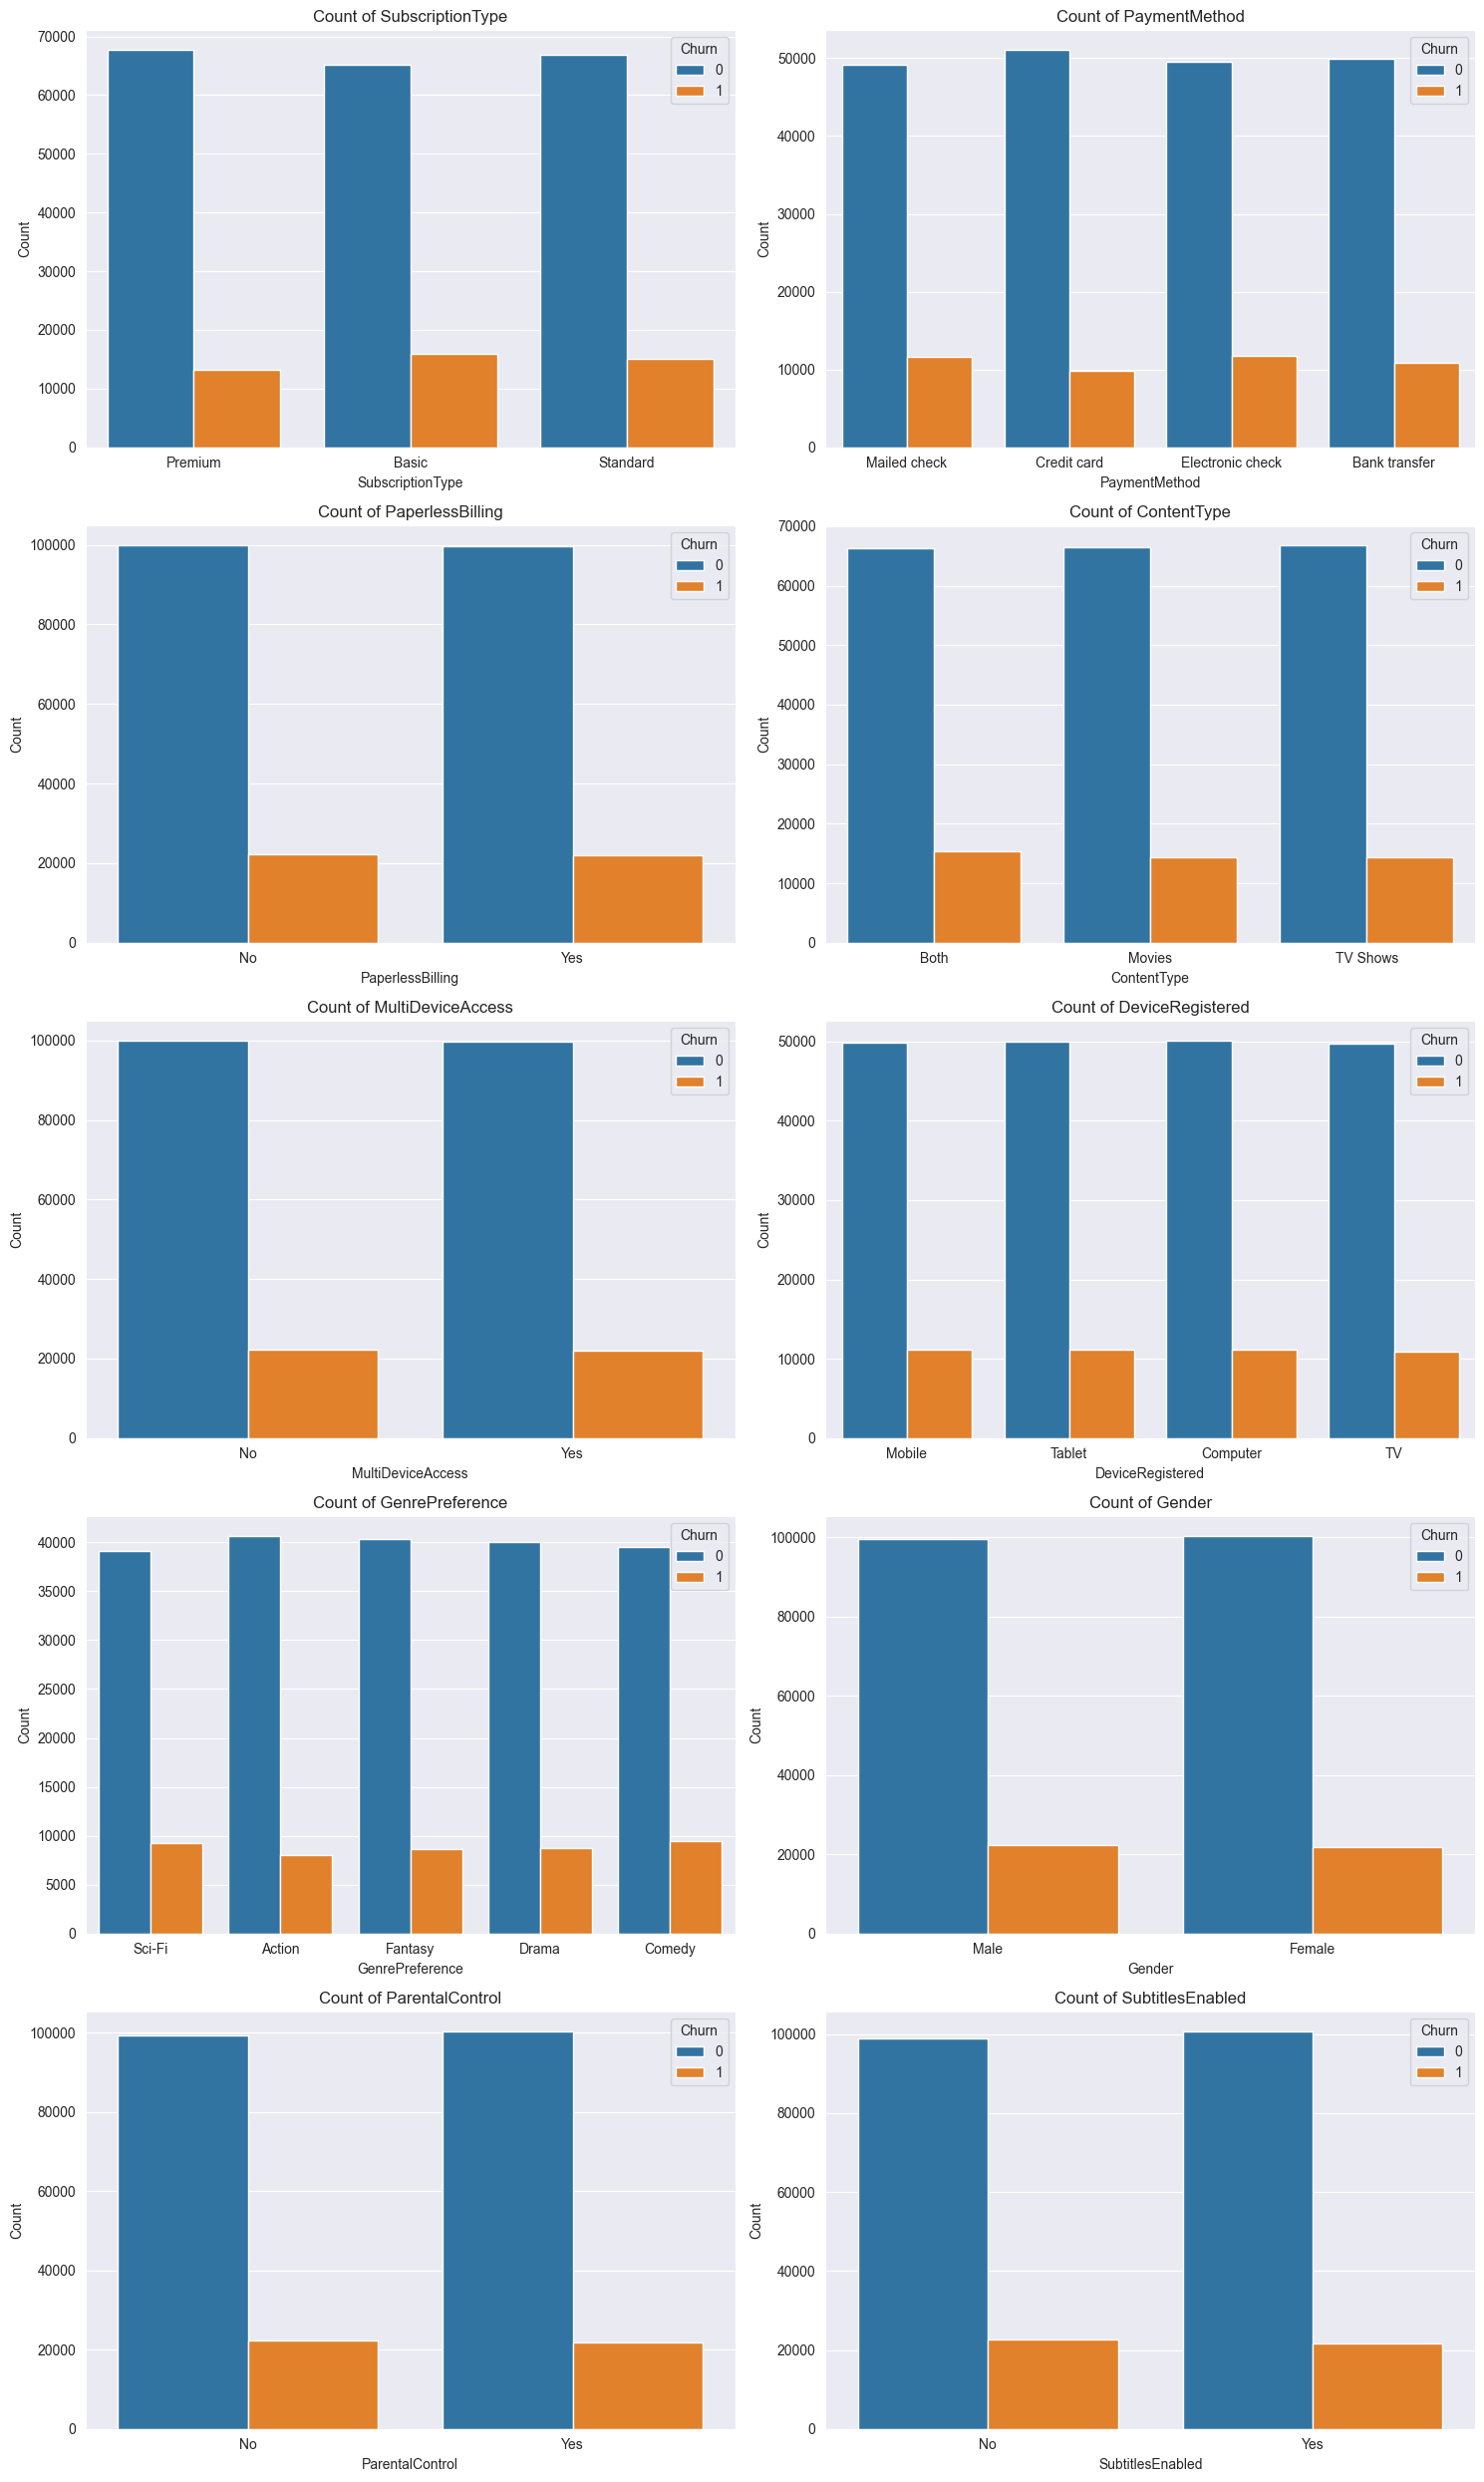

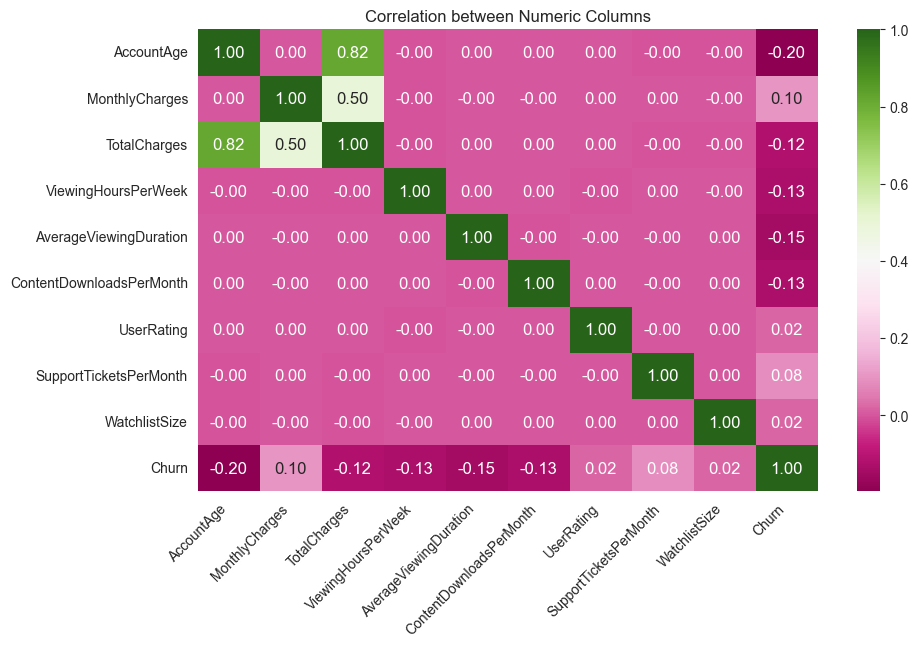

{'SubscriptionType': 0.03602862779086228, 'PaymentMethod': 0.031170586554433895, 'PaperlessBilling': 0.0, 'ContentType': 0.013040035827173132, 'MultiDeviceAccess': 0.0, 'DeviceRegistered': 0.0, 'GenrePreference': 0.026039199438169024, 'Gender': 0.007176137388359697, 'ParentalControl': 0.005135413975195599, 'SubtitlesEnabled': 0.012194370389054878}
  SubscriptionType  Churn Rate
0            Basic    0.196521
1          Premium    0.162775
2         Standard    0.184314
      PaymentMethod  Churn Rate
0     Bank transfer    0.179269
1       Credit card    0.162251
2  Electronic check    0.192471
3      Mailed check    0.190888
  PaperlessBilling  Churn Rate
0               No    0.181587
1              Yes    0.180876
  ContentType  Churn Rate
0        Both    0.188470
1      Movies    0.177764
2    TV Shows    0.177398
  MultiDeviceAccess  Churn Rate
0                No    0.181727
1               Yes    0.180736
  DeviceRegistered  Churn Rate
0         Computer    0.181350
1          

MemoryError: Unable to allocate 21.6 MiB for an array with shape (29, 195030) and data type int32

In [8]:
from ChurnPreditionModel import x_train, y_train, x_test, y_test

In [ ]:
# Standardize the feature set
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# Define the model with regularization and dropout
model = keras.Sequential([
    layers.Dense(
        64,
        activation='relu',
        input_shape=(x_train_scaled.shape[1],),
        kernel_regularizer=regularizers.l2(0.01),  # L2 regularization
    ),
    layers.BatchNormalization(),  # Batch normalization
    layers.Dropout(0.5),  # Increased dropout rate
    layers.Dense(
        32,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
    ),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Define early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,  # Number of epochs to wait before stopping if no improvement
#     restore_best_weights=True,  # Restore best weights after stopping
# )

# Train the model with early stopping and validation split
model.fit(
    x_train_scaled,
    y_train,
    epochs=50,  # Increase the number of epochs to let early stopping take effect
    batch_size=32,
    validation_split=0.2,  # Validation split for early stopping
    # callbacks=[early_stopping],  # Add early stopping callback
)

In [ ]:
# Predict on the test set
y_test_pred = model.predict(x_test_scaled) > 0.5

# Evaluate performance metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=100, batch_size=32):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
# Define cross-validation method with 5 folds
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Wrap the model in a KerasClassifier
# keras_clf = KerasClassifier(build_fn=lambda: build_model(x_train_scaled.shape[1]), epochs=20, batch_size=32)

# Perform cross-validation
keras_clf = KerasClassifierWrapper(build_fn=model, epochs=20, batch_size=32)
cross_val_scores = cross_val_score(keras_clf, x_train_scaled, y_train, cv=strat_kfold)

print("Cross-Validation Scores:", cross_val_scores)
print("Mean Score:", np.mean(cross_val_scores))

In [ ]:
# Output cross-validation results
mean_score = np.mean(cross_val_scores)
std_dev = np.std(cross_val_scores)

print(f"Mean Cross-Validation Score: {mean_score}")
print(f"Standard Deviation: {std_dev}")

# If you need more detailed evaluation on one fold (like the confusion matrix), perform a separate evaluation:
fold_indices = strat_kfold.split(x_train_scaled, y_train)

# Choose one of the folds for evaluation (e.g., first fold)
train_idx, val_idx = next(fold_indices)

x_train_fold = x_train_scaled[train_idx]
y_train_fold = y_train[train_idx]
x_val_fold = x_train_scaled[val_idx]
y_val_fold = y_train[val_idx]

keras_clf.fit(x_train_fold, y_train_fold)

y_val_pred = keras_clf.predict(x_val_fold) > 0.5  # Convert probabilities to binary predictions

# Evaluate on this fold
conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Validation Fold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
def evaluate_model_performance(y_true, y_pred):
    """
    Evaluate the performance of a model with common metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
# Predict the test data
y_test_pred = model.predict(x_test_scaled) > 0.5  # Convert probabilities to binary predictions

# Evaluate the model performance
evaluate_model_performance(y_test, y_test_pred)